# Marathi2Vec Language Modeling

Thanks to NirantK and cstorm125 for the works Hindi2Vec and Thai2Vec, both of which helped me make this notebook. 

The goal of this notebook is to train Marathi word embeddings using the fast.ai version of AWD LSTM with dropouts, the data was fulled from Wikipedia.

A perplexity of was achieved, there has been no comparable research work in Marathi Language at the point of writing. (2nd October, 2018)


In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import dill as pickle
import json 
import re

from IPython.display import Image
from IPython.core.display import HTML

import torchtext
from torchtext import vocab
from torchtext import data as d
from torchtext.datasets import language_modeling

In [4]:
from fastai.learner import *
from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

In [13]:

!cd Data


Data  LICENSE  Marathi2Vec.ipynb  README.md


 - Download or clone WikiExtractor from github
 - To run on windows look at [this](https://github.com/attardi/wikiextractor/issues/89#issuecomment-272062219).
 
 Run the following command :
 
 ```python WikiExtractor.py mrwiki-latest-pages-articles.xml -o extract -b 10M --ignored_tags abbr,b,big --discard_elements gallery,timeline,noinclude```

In [6]:
data = 'Data/'
extract= f'{data}extract/'
train_set = f'{data}train/'
valid_set = f'{data}valid/'
models = f'{data}models/'


In [20]:
%%time
%%prun



ext =  !ls {extract}

def cleanFile(extracted_filelist, dest):    
    cleaned_all = []
    for ext_file in extracted_filelist:
        input_file = f'{extract}{ext_file}'
        with open(input_file,'r', encoding='utf-8') as f:
            raw_txt = f.readlines()
            cleaned_doc = []
            for line in raw_txt:
                new_line = re.sub('<[^<]+?>', '', line)
                new_line = re.sub('__[^<]+?__', '', new_line) 
                new_line = new_line.strip()
                if new_line != '':
                    cleaned_doc.append(new_line)

            new_doc = "\n".join(cleaned_doc)
            cleaned_all.append(new_doc)
            with open(f"{dest}{ext_file}.txt", "w", encoding='utf-8') as text_file:
                text_file.write(new_doc)
    return cleaned_all

cleaned_all = cleanFile(ext, train_set)



 CPU times: user 3.48 s, sys: 164 ms, total: 3.64 s
Wall time: 3.69 s


## Create Validation Set

In [4]:
import random
random.seed(782)

training_files = !ls {train_set}
validation_files = !ls {valid_set} 
split = int(0.2 * len(training_files)) #Doing a 80-20 split
random.shuffle(training_files)
validation_files = training_files[:split]
training_files = training_files[split:]

print(validation_files)
print(training_files)

['wiki_00.txt', 'wiki_06.txt']
['wiki_09.txt', 'wiki_07.txt', 'wiki_03.txt', 'wiki_02.txt', 'wiki_08.txt', 'wiki_05.txt', 'wiki_04.txt', 'wiki_01.txt']


In [5]:
import shutil, os
for root, dirs, files in os.walk(train_set):
     for file in files:
         if file.endswith(".txt") & (file in validation_files):
             shutil.move(os.path.join(root, file),valid_set)
trn_files = !ls {train_set}
val_files = !ls {valid_set}
print(trn_files), print(val_files), print(len(trn_files)), print(len(val_files))

['wiki_01.txt', 'wiki_02.txt', 'wiki_03.txt', 'wiki_04.txt', 'wiki_05.txt', 'wiki_07.txt', 'wiki_08.txt', 'wiki_09.txt']
['wiki_00.txt', 'wiki_06.txt']
8
2


(None, None, None, None)

# Text Processing

There aren't any known Marathi Stemmers available in Python, So i've written these porting taking inspiration from Spacy's hindi tokenizer and stemmer, Since Marathi and Hindi Inherently come from the same script i.e Devanagri.

In [7]:
 from cltk.tokenize.sentence import TokenizeSentence

In [8]:
def word_tokenize(document):
    tokenizer = TokenizeSentence('marathi')
    return tokenizer.tokenize(document)
    
def docs_tokenize(documents_as_lists):   
    for document in documents_as_lists:
        tokens = word_tokenize(document)
        tokens_list.extend(tokens)
    
    return tokens_list

In [7]:
%%time
tokens_filename = "tokens_list.txt"
tokens_list = []

#TODO refactor from try except blocks to if else with if statement checking if file exists using Pathlib

try:
    print(f'Reading from {tokens_filename}')
    with open(tokens_filename, "r") as f:
         tokens_list = json.load(f)
    
except FileNotFoundError:
    print(f'FileNotFound. Trying to tokenize from cleaned_all')
    tokens_list = docs_tokenize(cleaned_all)
    
    with open('tokens_list.txt', 'w') as outfile:
        json.dump(tokens_list, outfile)

print(f'Found {len(tokens_list)} tokens')

Reading from tokens_list.txt
Found 6307733 tokens
CPU times: user 4.4 s, sys: 268 ms, total: 4.67 s
Wall time: 4.69 s


In [9]:

assert torch.cuda.is_available()
#assert torch.backends.cudnn .cudnn.is_available()
#print(torch.backends.cudnn.is_acceptable(torch.cuda.FloatTensor(1)))
#print(torch.backends.cudnn.version())
#print(torch.backends.cudnn.version())
#assert torch.backends.cudnn.enabled()

In [9]:
TEXT = d.Field(lower=True, tokenize=word_tokenize)
#batch size
bs=16
#backprop through time
bptt=70
test_set = f'{data}test/'

In [10]:
FILES = dict(train=f'{train_set}', validation=f'{valid_set}', test=f'{test_set}')

In [11]:
%%time
md = LanguageModelData.from_text_files('', TEXT, **FILES, bs=bs, bptt=bptt, min_freq=50)

CPU times: user 32.4 s, sys: 1.99 s, total: 34.4 s
Wall time: 37.1 s


In [15]:
%%time
pickle.dump(TEXT, open(f'{data}//models//TEXT_min_freq50.pkl','wb'))

CPU times: user 447 ms, sys: 19.6 ms, total: 467 ms
Wall time: 466 ms


In [16]:
len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(5695, 10883, 1, 6379809)

In [17]:
TEXT.vocab.itos[:12]

['<unk>', '<pad>', '.', ',', 'आहे', '-', ')', 'या', 'आणि', '(', 'व', 'हे']

In [20]:
TEXT.vocab.stoi['आ']

2449

In [21]:
md.trn_ds[0].text[:12]

['पायरट्स',
 'ऑफ',
 'द',
 'कॅरिबियन',
 '-',
 'अॅट',
 'वर्ल्ड्स',
 'एंड',
 '(',
 'चित्रपट',
 ')',
 'पायरट्स']

In [22]:
next(iter(md.trn_dl))

(tensor([[   0,    0,    2,  ...,   21,    0, 1141],
         [ 182,  739,  315,  ..., 5105,   41, 6403],
         [ 265,    0, 4817,  ...,  217, 8074,   11],
         ...,
         [ 118,    0, 3121,  ...,  173,   11,    4],
         [   2,   61,   18,  ..., 4224,  383,    2],
         [1354,    0,    2,  ...,   21,    0, 5834]], device='cuda:0'),
 tensor([ 182,  739,  315,  ...,  378,   60, 4220], device='cuda:0'))

In [17]:
#trn_ds is list; one for each txt file
txt = md.trn_ds[0].text[:10]
TEXT.numericalize([txt])

tensor([[   0],
        [ 182],
        [ 265],
        [4577],
        [   5],
        [   0],
        [   0],
        [   0],
        [   9],
        [ 107]], device='cuda:0')

In [12]:
em_sz = 300  # size of each embedding vector
nh = 500     # number of hidden activations per layer
nl = 3       # number of layers

In [13]:


opt_fn = partial(optim.Adam, betas=(0.7, 0.99))



In [14]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
               dropouti=0.05, dropout=0.05, wdrop=0.1, dropoute=0.02, dropouth=0.05)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=0.3

 77%|███████▋  | 4390/5695 [19:32<05:48,  3.75it/s, loss=19]  

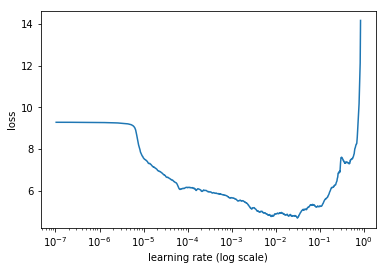

In [15]:
#find suitable learning rates
learner.lr_find(1e-07,1e2)

learner.sched.plot()

In [ ]:
learner.fit(1e-4, 4, wds=1e-6, cycle_len=1, cycle_mult=2)
learner.save_encoder('adam1_enc')

epoch      trn_loss   val_loss                                
    0      5.477827   5.596106  
 73%|███████▎  | 4160/5695 [18:54<06:58,  3.67it/s, loss=4.87]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    1      5.045255   5.181519                                
 14%|█▍        | 795/5695 [03:36<22:17,  3.66it/s, loss=5.07]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 55%|█████▌    | 3141/5695 [14:16<11:36,  3.67it/s, loss=4.94]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 95%|█████████▍| 5389/5695 [24:34<01:23,  3.66it/s, loss=4.92]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 32%|███▏      | 1837/5695 [08:06<17:02,  3.77it/s, loss=4.89]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 73%|███████▎  | 4175/5695 [18:24<06:42,  3.78it/s, loss=4.47]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    3      4.70627    4.850859                                
    4      4.589127   4.694453                                
 58%|█████▊    | 3323/5695 [15:01<10:43,  3.69it/s, loss=4.51]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 95%|█████████▌| 5420/5695 [24:28<01:14,  3.69it/s, loss=4.45]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 36%|███▌      | 2055/5695 [09:06<16:07,  3.76it/s, loss=4.6] 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 73%|███████▎  | 4161/5695 [18:23<06:46,  3.77it/s, loss=4.2] 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    6      4.457709   4.598827                                
 11%|█▏        | 652/5695 [02:52<22:12,  3.78it/s, loss=4.53]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 28%|██▊       | 1602/5695 [07:03<18:03,  3.78it/s, loss=4.31]